# Association Rules
- Transaction Definition
- Observation & Discretization
- Assocation Rules
- Explanation



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import time
import statistics
from sklearn.cluster import KMeans
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 40, 35
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 25

# Dataset cleaner
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    # return df[indices_to_keep].astype(np.float64)
    return df[indices_to_keep]

# Data 2 - Weather
- 從 2016-07-03 到 2017-07-03 的天氣資料
- 29 個地點
- 每小時一筆資料

In [2]:
weather = pd.read_csv("weather.csv")
weather.head()

,Location,Date,Time,測站氣壓,溫度,相對溼度,風速,風向,降水量,日照時數
0,"BANQIAO,板橋",2016-07-03,01:00,1009.6,25.3,83.0,1.0,"南南西,SSW",0.0,NaN
1,"BANQIAO,板橋",2016-07-03,02:00,1009.0,25.1,84.0,0.2,"靜風,Calm",0.0,NaN
2,"BANQIAO,板橋",2016-07-03,03:00,1008.6,25.1,84.0,0.2,"靜風,Calm",0.0,NaN
3,"BANQIAO,板橋",2016-07-03,04:00,1009.0,25.0,85.0,0.8,"南南西,SSW",0.0,NaN
4,"BANQIAO,板橋",2016-07-03,05:00,1009.5,24.8,85.0,0.6,"西南,WS",0.0,NaN


In [3]:
weather.describe()

,測站氣壓,溫度,相對溼度,風速,日照時數
count,254583.000000,254576.000000,254576.000000,254538.000000,148526.000000
mean,978.468847,22.336851,78.289953,3.144237,0.330544
std,81.001907,6.522794,11.620914,2.740838,0.420622
min,617.900000,-10.200000,0.000000,0.000000,-9.500000
25%,998.400000,18.600000,71.000000,1.300000,0.000000
50%,1006.900000,23.400000,79.000000,2.400000,0.000000
75%,1013.300000,27.100000,87.000000,4.200000,0.800000
max,1031.900000,38.300000,100.000000,42.700000,1.000000


## Task 1: Association Analysis of Temperature, Humidity, Wind speed, and Pressure

### Step 1: Transaction Definition:

Through discovering the association rules among temperature, humidity, wind speed, and pressure, I would like to find out what are combinations of humidity, wind speed, and pressure that will infer hot or cold weather (temperatrue). Hence, we could suggest people's wearing without having to know the current temperature based on the rules.

In [4]:
# axis = 1: Drop selected column
q1 = weather.drop(['Location', 'Date', 'Time', '風向', '降水量', '日照時數'], axis=1)

# Clean up the dataset to get rid of nan, inf and -inf
q1 = clean_dataset(q1)
q1.head()

,測站氣壓,溫度,相對溼度,風速
0,1009.6,25.3,83.0,1.0
1,1009.0,25.1,84.0,0.2
2,1008.6,25.1,84.0,0.2
3,1009.0,25.0,85.0,0.8
4,1009.5,24.8,85.0,0.6


### Step 2: Observation & Discretization:

Text(0,0.5,'count')

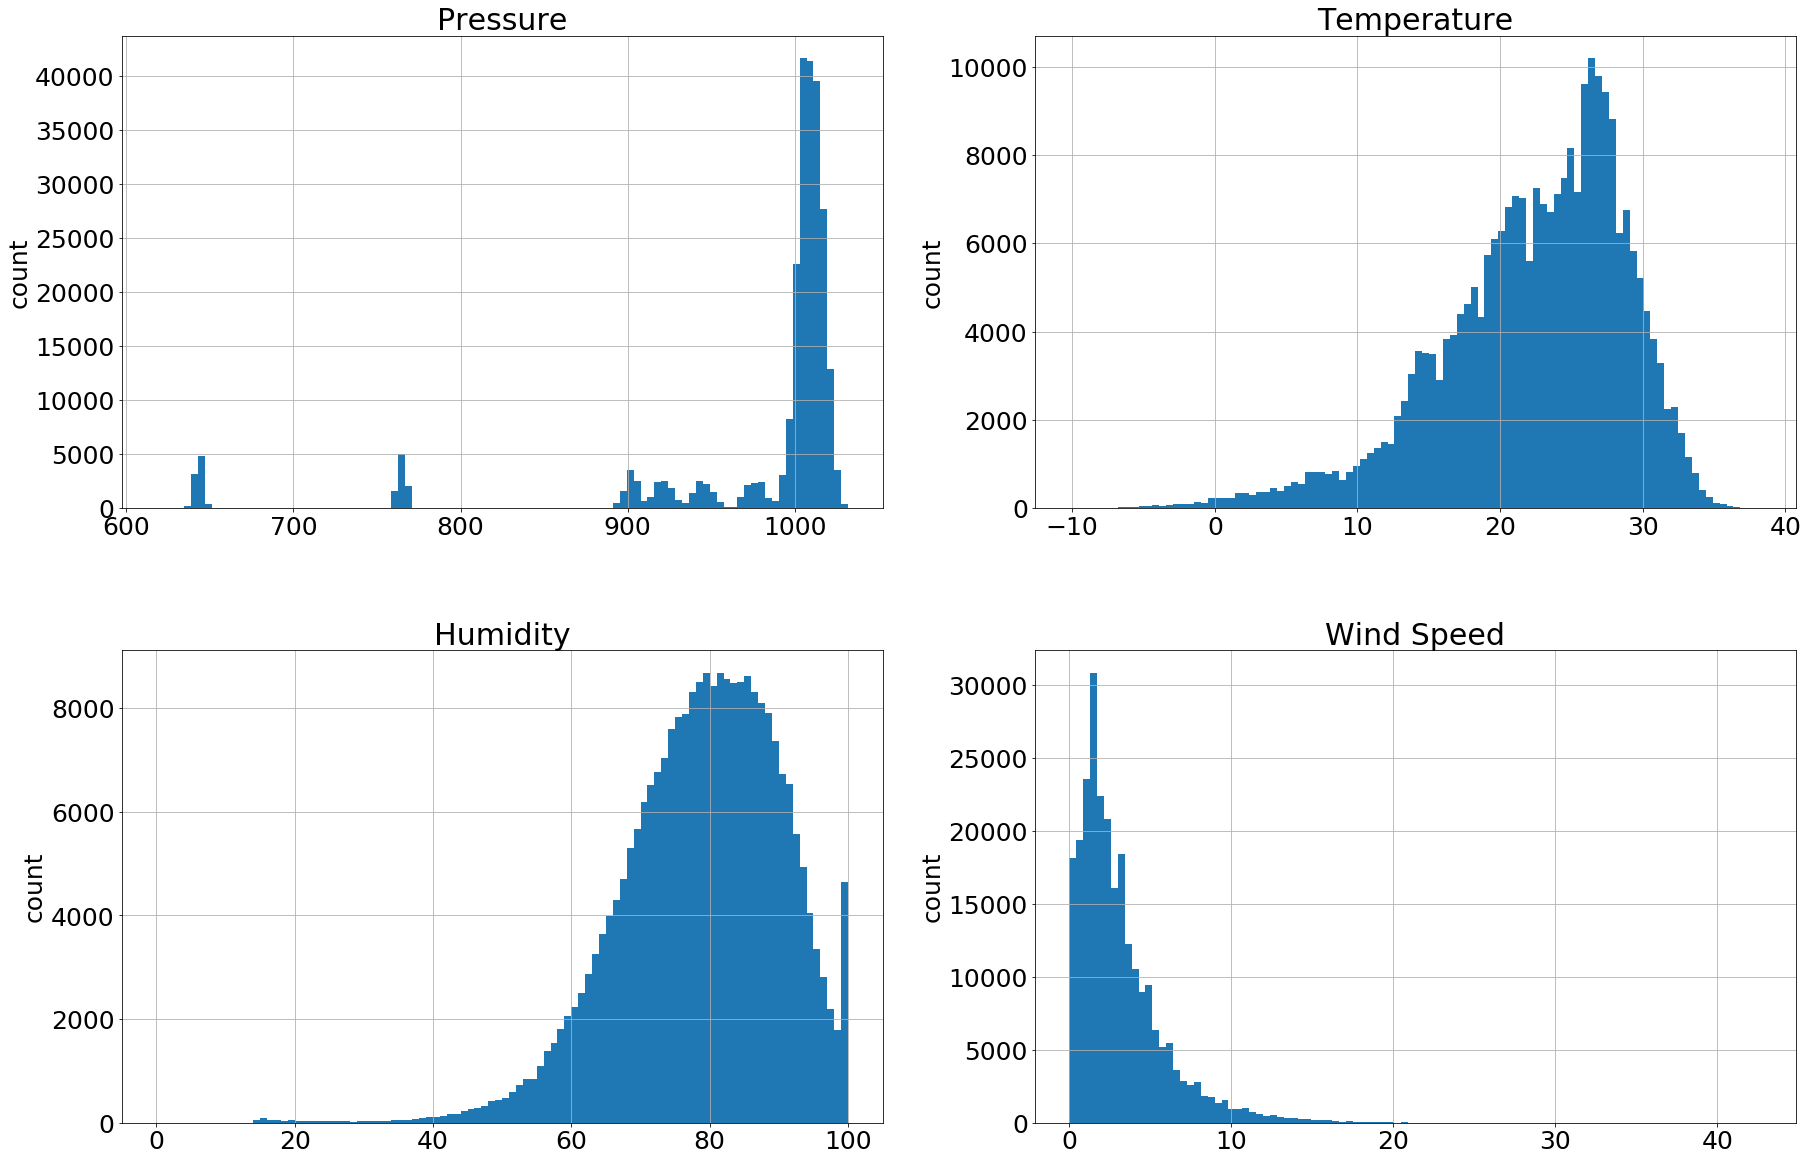

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
plt.rcParams.update({'font.size': 25})
fig.subplots_adjust(hspace=.3)

plt.subplot(2, 2, 1)
q1['測站氣壓'].hist(bins = 100)
plt.title('Pressure')
plt.ylabel('count')

plt.subplot(2, 2, 2)
q1['溫度'].hist(bins = 100)
plt.title('Temperature')
plt.ylabel('count')

plt.subplot(2, 2, 3)
q1['相對溼度'].hist(bins = 100)
plt.title('Humidity')
plt.ylabel('count')

plt.subplot(2, 2, 4)
q1['風速'].hist(bins = 100)
plt.title('Wind Speed')
plt.ylabel('count')

# # Standard Deviation
# q1_p_norm = [q1['測站氣壓'] / q1['測站氣壓'].max()]
# print("Pressure std = %f" % np.std(q1_p_norm[0]))
# q1_t_norm = [q1['溫度'] / q1['溫度'].max()]
# print("Temperature std = %f" % np.std(q1_t_norm[0]))
# q1_h_norm = [q1['相對溼度'] / q1['相對溼度'].max()]
# print("Humidity std = %f" % np.std(q1_h_norm[0]))
# q1_w_norm = [q1['風速'] / q1['風速'].max()]
# print("Wind speed std = %f" % np.std(q1_w_norm[0]))

#### From the figures above, we observe that
1. Temperature can be discretized into three main regions using k-means algorithm
    - (0, 15]: Heavy coat is recommended.
    - (15, 25]: Long shirt with jacket is recommended.
    - (25, 40]: Short shirts and short pants are recommended.
2. Distributions of pressure, humidity, and wind speed are not evenly distributed, so using equal-frequency discretization (qcut) is more suitable in order to increase clusters' support.

#### K-means clustering for temperature.

In [6]:
X = q1[['溫度']]

t_kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
q1['T_cluster'] = t_kmeans.labels_
q1.head()
# q1[q1['t_kmeans'] == 0].head()
# q1[q1['t_kmeans'] == 1].head()
# q1[q1['t_kmeans'] == 2].head()

,測站氣壓,溫度,相對溼度,風速,T_cluster
0,1009.6,25.3,83.0,1.0,0
1,1009.0,25.1,84.0,0.2,0
2,1008.6,25.1,84.0,0.2,0
3,1009.0,25.0,85.0,0.8,0
4,1009.5,24.8,85.0,0.6,0


In [7]:
# Check k-means clusters
# q1.groupby('T_cluster')['測站氣壓', '溫度', '相對溼度', '風速'].mean()
q1.groupby('T_cluster').count()

,測站氣壓,溫度,相對溼度,風速
T_cluster,,,,
0,119715,119715,119715,119715
1,98006,98006,98006,98006
2,36768,36768,36768,36768


In [8]:
# Notify the upper/lower bounds of T_cluster
max_list = list(q1.groupby('T_cluster')['溫度'].max())
min_list = list(q1.groupby('T_cluster')['溫度'].min())

# Modify T_cluster's value by specific upper/lower bounds
q1[['T_cluster']] = ["[%d, %d]" % (min_list[i], max_list[i]) for i in q1['T_cluster']]
q1.head()

,測站氣壓,溫度,相對溼度,風速,T_cluster
0,1009.6,25.3,83.0,1.0,"[24, 38]"
1,1009.0,25.1,84.0,0.2,"[24, 38]"
2,1008.6,25.1,84.0,0.2,"[24, 38]"
3,1009.0,25.0,85.0,0.8,"[24, 38]"
4,1009.5,24.8,85.0,0.6,"[24, 38]"


In [9]:
# Check
q1.groupby('T_cluster').count()

,測站氣壓,溫度,相對溼度,風速
T_cluster,,,,
"[-10, 15]",36768,36768,36768,36768
"[15, 23]",98006,98006,98006,98006
"[24, 38]",119715,119715,119715,119715


#### Let's examine the k-means results regarding temperature clustering shown in the above table
Temperature clustering result:

- [-10, 15]: It is somewhat freezing, so: Heavy coat is recommended.
- [15, 23]: Moderate temperature, so: Long shirt with jacket is recommended.
- [24, 38]: It is rather how, so: Short shirts and short pants are recommended.

The clustering by k-means coincides with our expectation as shown in the observation step.

#### Equal-frequency discretization for pressure, humidity, and wind speed.

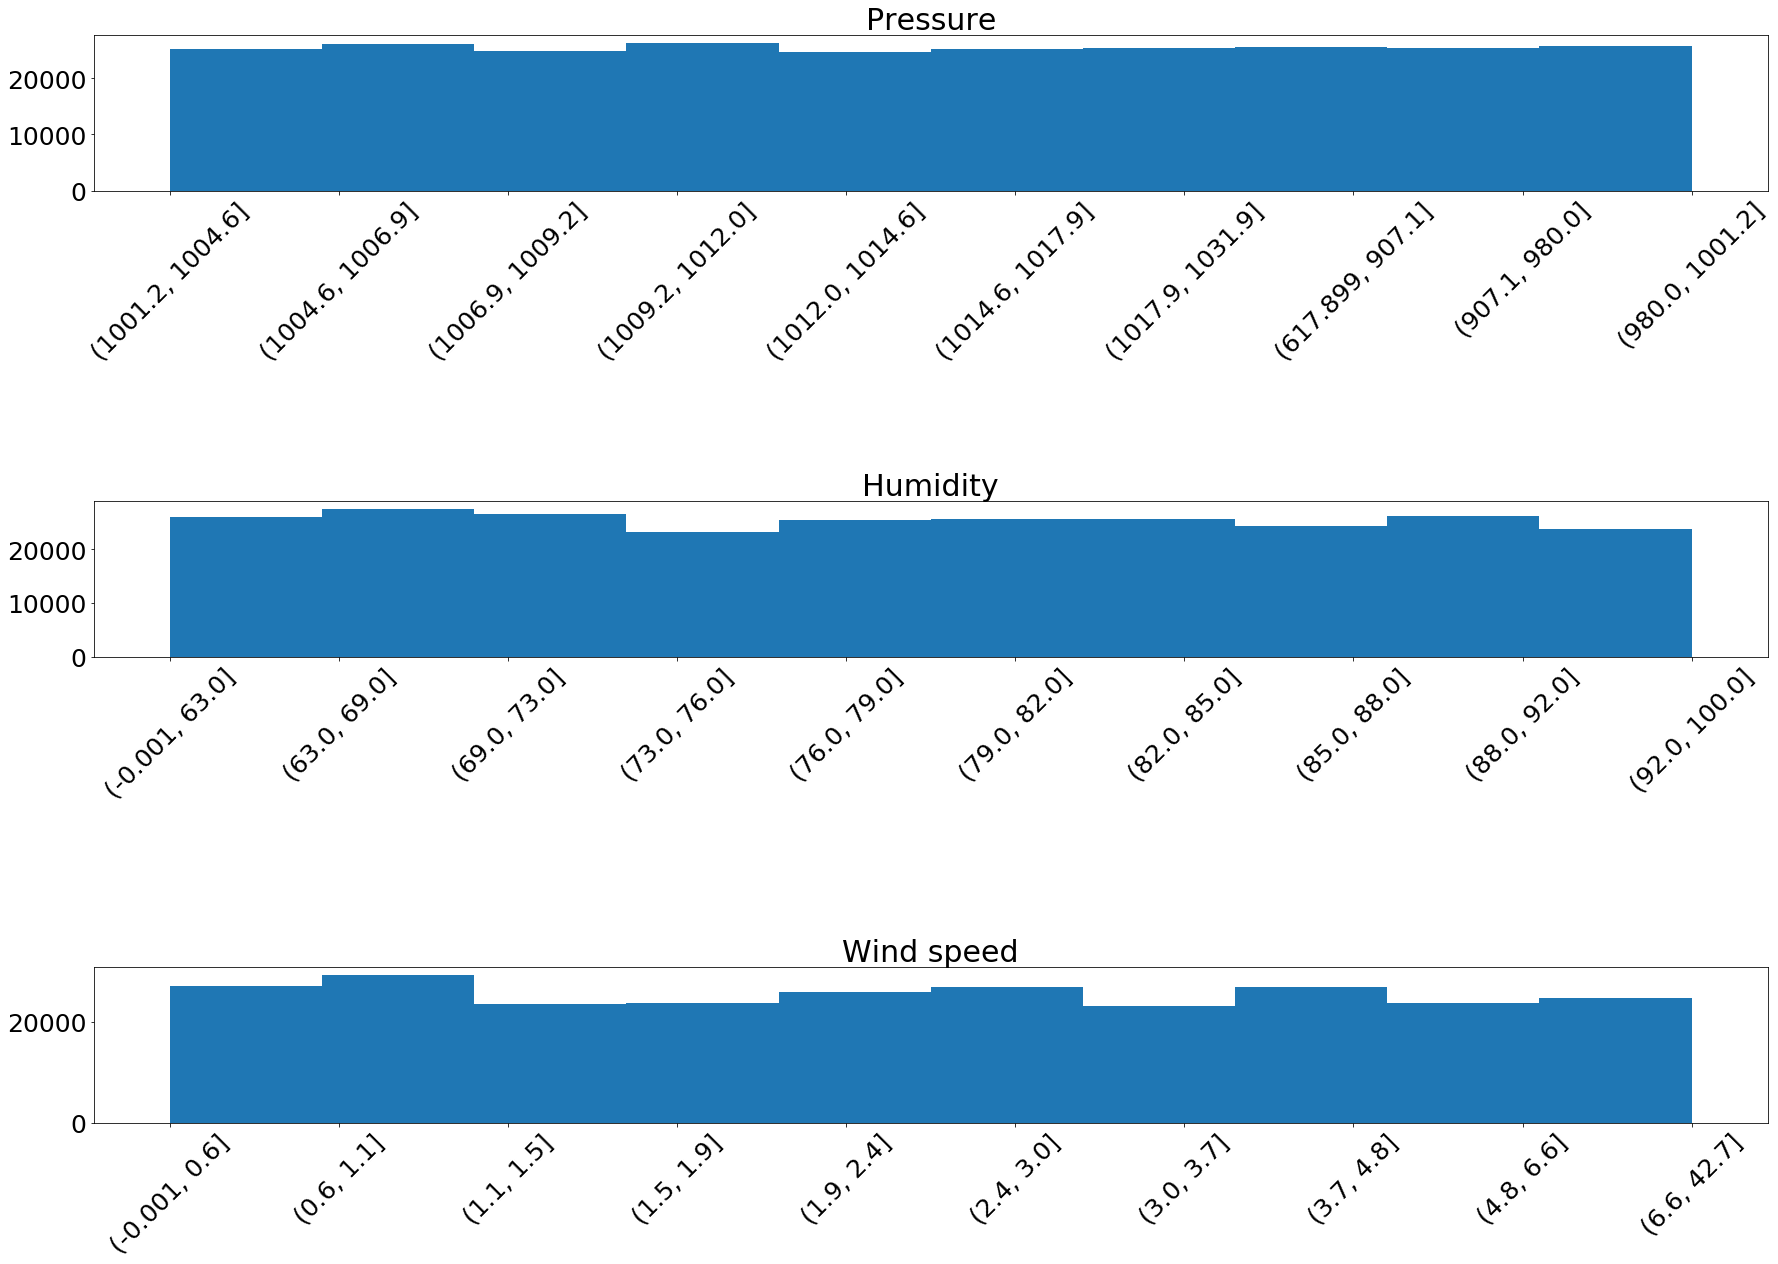

In [10]:
result = []
result.append(pd.qcut(q1['測站氣壓'], 10))
result.append(pd.qcut(q1['相對溼度'], 10))
result.append(pd.qcut(q1['風速'], 10))

plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(3,1, figsize=(30, 20))
plt.rcParams.update({'font.size': 25})
fig.subplots_adjust(hspace=2)
title = ['Pressure', 'Humidity', 'Wind speed']
for i in range(len(result)):
    result[i] = [str(x) for x in result[i]]
    ax[i].hist(result[i])
    ax[i].set_title(title[i])
    for tick in ax[i].get_xticklabels():
        # tick.set_y(1)
        tick.set_rotation(45)

### Step 3: Association Rules by FP-Growth:

In [11]:
# Add prefix for clarification
temp_items = ['Temp' + x for x in q1['T_cluster']]
pres_items = ['Pres' + x for x in result[0]]
humi_items = ['Humi' + x for x in result[1]]
wind_items = ['wind' + x for x in result[2]]

dataset = []
dataset.append(temp_items)
dataset.append(pres_items)
dataset.append(humi_items)
dataset.append(wind_items)

# Transpose to generater the format of transactions
transactions = list(zip(*dataset))
transactions

[('Temp[24, 38]',
  'Pres(1009.2, 1012.0]',
  'Humi(82.0, 85.0]',
  'wind(0.6, 1.1]'),
 ('Temp[24, 38]',
  'Pres(1006.9, 1009.2]',
  'Humi(82.0, 85.0]',
  'wind(-0.001, 0.6]'),
 ('Temp[24, 38]',
  'Pres(1006.9, 1009.2]',
  'Humi(82.0, 85.0]',
  'wind(-0.001, 0.6]'),
 ('Temp[24, 38]',
  'Pres(1006.9, 1009.2]',
  'Humi(82.0, 85.0]',
  'wind(0.6, 1.1]'),
 ('Temp[24, 38]',
  'Pres(1009.2, 1012.0]',
  'Humi(82.0, 85.0]',
  'wind(-0.001, 0.6]'),
 ('Temp[24, 38]',
  'Pres(1009.2, 1012.0]',
  'Humi(82.0, 85.0]',
  'wind(0.6, 1.1]'),
 ('Temp[24, 38]',
  'Pres(1009.2, 1012.0]',
  'Humi(82.0, 85.0]',
  'wind(-0.001, 0.6]'),
 ('Temp[24, 38]',
  'Pres(1009.2, 1012.0]',
  'Humi(73.0, 76.0]',
  'wind(-0.001, 0.6]'),
 ('Temp[24, 38]',
  'Pres(1009.2, 1012.0]',
  'Humi(69.0, 73.0]',
  'wind(-0.001, 0.6]'),
 ('Temp[24, 38]',
  'Pres(1009.2, 1012.0]',
  'Humi(-0.001, 63.0]',
  'wind(-0.001, 0.6]'),
 ('Temp[24, 38]',
  'Pres(1006.9, 1009.2]',
  'Humi(-0.001, 63.0]',
  'wind(-0.001, 0.6]'),
 ('Temp[24, 38]

#### FP-Growth:
Orange3-fpgrowth can only deal with numeric data, so a pair of encoder/decoder is required

In [12]:
# Orange3's input must be mumeric. String is not allowed.
from orangecontrib.associate import fpgrowth as fpg
start = time.time()

itemset = set().union(*transactions)
# decoder: numeric to string
decoder = {i: k for i, k in enumerate(itemset)}
# encoder: string to numeric
encoder = {k: i for i, k in enumerate(itemset)}

# Set min. support and min. confidence
# Fine-tuning minsup and minconf can get us more insight! Try different values of them.
minsup = 500/len(transactions)
minconf = 0.8

itemsets =  dict(fpg.frequent_itemsets([[encoder[i] for i in t] for t in transactions], minsup))
rules = list(fpg.association_rules(itemsets, minconf))

print("Fpgrowth took", time.time() - start, "seconds.")
# Print # of rules
print(len(rules), "Results")

Fpgrowth took 1.4587111473083496 seconds.
68 Results


In [13]:
for rule in rules:
    a = [decoder[i] for i in rule[0]]
    b = [decoder[i] for i in rule[1]]
    s, c = rule[2], rule[3]
    print(a, ' -> ', b, c)
# c = confidence
# a -> b is the rule

['wind(-0.001, 0.6]', 'Humi(88.0, 92.0]', 'Pres(907.1, 980.0]']  ->  ['Temp[15, 23]'] 0.8157894736842105
['Humi(92.0, 100.0]', 'Pres(617.899, 907.1]', 'wind(3.7, 4.8]']  ->  ['Temp[-10, 15]'] 0.9593908629441624
['wind(6.6, 42.7]', 'Humi(92.0, 100.0]', 'Pres(617.899, 907.1]']  ->  ['Temp[-10, 15]'] 0.9343163538873994
['wind(4.8, 6.6]', 'Pres(617.899, 907.1]', 'Humi(92.0, 100.0]']  ->  ['Temp[-10, 15]'] 0.978021978021978
['wind(-0.001, 0.6]', 'Pres(1004.6, 1006.9]']  ->  ['Temp[24, 38]'] 0.8149659863945579
['wind(3.7, 4.8]', 'Pres(1004.6, 1006.9]']  ->  ['Temp[24, 38]'] 0.8654471544715447
['Humi(69.0, 73.0]', 'Pres(1004.6, 1006.9]']  ->  ['Temp[24, 38]'] 0.8991949597479874
['Humi(63.0, 69.0]', 'Pres(1004.6, 1006.9]']  ->  ['Temp[24, 38]'] 0.9195193008011653
['wind(0.6, 1.1]', 'Pres(1004.6, 1006.9]']  ->  ['Temp[24, 38]'] 0.8793157076205288
['wind(2.4, 3.0]', 'Pres(1004.6, 1006.9]']  ->  ['Temp[24, 38]'] 0.8682942499196916
['Humi(-0.001, 63.0]', 'Pres(1004.6, 1006.9]']  ->  ['Temp[24, 38]

In [14]:
# decoder

In [15]:
# encoder

### Step 4: Explanation and Conclusion
- [Low pressure + high wind speed] -> [low temperature], wearing heavy coat is recommended!
    - Rules:
        - ['wind(3.7, 4.8]', 'Pres(617.899, 907.1]']  ->  ['Temp[-10, 15]'] 0.9547325102880658
        - ['Pres(617.899, 907.1]', 'wind(6.6, 42.7]']  ->  ['Temp[-10, 15]'] 0.9714434060228453
        - ['Pres(617.899, 907.1]', 'wind(4.8, 6.6]']  ->  ['Temp[-10, 15]'] 0.9831932773109243
        - ['wind(3.0, 3.7]', 'Pres(617.899, 907.1]']  ->  ['Temp[-10, 15]'] 0.8697282099343955
    - In short, Pressure < 907.1 + Wind > 3.7 -> Temperature < 15 can be easily oberseved in the above rules.
    - Recall that Temp[-10, 15] means that the weather is freezing, so heavy coat is recommended when the pressure is within the range of (617.899, 907.1] and the wind speed is stronger than 3.7.
    - Interpretations: The observation makes sense, since low pressure probably means high altitude areas such as mountain areas. Mountain areas are usually cold so the temperature is low. Furthermore, mountain areas are also windy. As a result, low pressure with high wind speed implies low temperature with a high confidence. At the circumstances, people better wear heavy coat to keep warm!
    - Setting: minsup = 500/len(transactions), minconf = 0.8

## Task 2: Association Analysis of Time, Temperature, Humidity, and, Wind Speed

### Step 1: Transaction Definition:
By observing the association rules among time, temperature, humidity, and wind speed, I try to find out what is the weather like during day time and night time, respectively.

In [16]:
# axis = 1: Drop selected column
q1 = weather.drop(['Location', 'Date', '風向', '測站氣壓', '降水量', '日照時數'], axis=1)

# Clean up the dataset to get rid of nan, inf and -inf
q1 = clean_dataset(q1)
q1.head()

,Time,溫度,相對溼度,風速
0,01:00,25.3,83.0,1.0
1,02:00,25.1,84.0,0.2
2,03:00,25.1,84.0,0.2
3,04:00,25.0,85.0,0.8
4,05:00,24.8,85.0,0.6


In [17]:
q1.groupby('Time').mean()

,溫度,相對溼度,風速
Time,,,
01:00,21.101867,81.448520,2.830605
02:00,20.979436,81.714501,2.826023
03:00,20.866519,81.951631,2.839440
04:00,20.770215,82.088629,2.848095
05:00,20.688835,82.142951,2.831674
06:00,20.706780,82.183781,2.841169
07:00,21.215361,81.288449,2.788760
08:00,22.164668,79.100802,2.853484
09:00,23.122765,76.405319,3.034317


### Step 2: Observation & Discretization:

Text(0,0.5,'count')

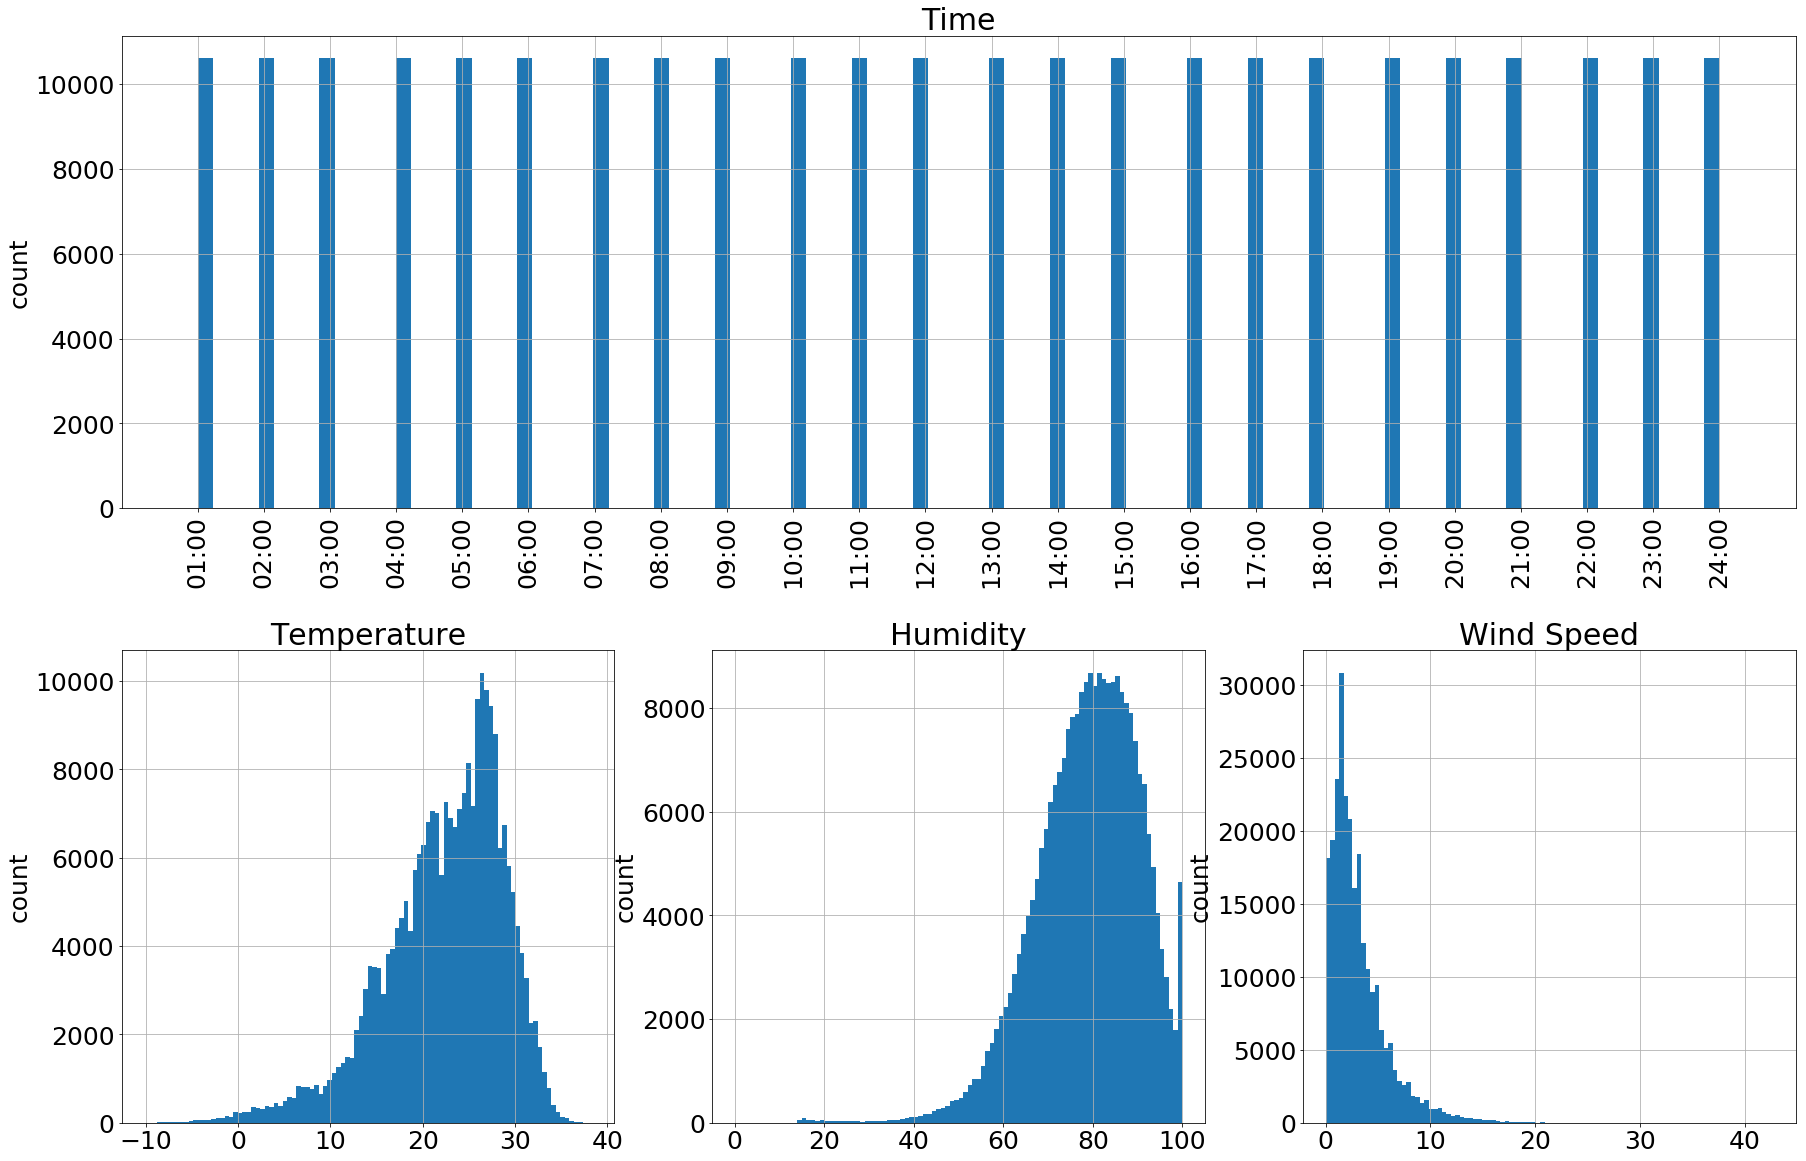

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
plt.rcParams.update({'font.size': 25})
fig.subplots_adjust(hspace=.3)

plt.subplot(2, 1, 1)
q1['Time'].hist(bins = 100)
plt.xticks(rotation='vertical')
plt.title('Time')
plt.ylabel('count')

plt.subplot(2, 3, 4)
q1['溫度'].hist(bins = 100)
plt.title('Temperature')
plt.ylabel('count')

plt.subplot(2, 3, 5)
q1['相對溼度'].hist(bins = 100)
plt.title('Humidity')
plt.ylabel('count')

plt.subplot(2, 3, 6)
q1['風速'].hist(bins = 100)
plt.title('Wind Speed')
plt.ylabel('count')

#### From the figures above, we observe that
1. Time is evenly distributed. Based on the knowledge of sunrise and sunset time, Time is discretized into two regions:
    - Day time: 07:00 to 18:00
    - Night time: 19:00 to 06:00
2. Temperature can be discretized into ten regions using k-means algorithm
3. Distributions of humidity and wind speed are not evenly distributed, so using equal-frequency discretization (qcut) is more suitable in order to increase clusters' support.

#### Time discretization

In [19]:
# Day time:
q1.loc[(q1['Time'] >= '07:00') & (q1['Time'] <= '18:00'), 'Time_discre'] = 'Day'
# Night time:
q1.loc[(q1['Time'] >= '19:00') | (q1['Time'] <= '06:00'), 'Time_discre'] = 'Night'

In [20]:
q1.head(24)

,Time,溫度,相對溼度,風速,Time_discre
0,01:00,25.3,83.0,1.0,Night
1,02:00,25.1,84.0,0.2,Night
2,03:00,25.1,84.0,0.2,Night
3,04:00,25.0,85.0,0.8,Night
4,05:00,24.8,85.0,0.6,Night
5,06:00,25.0,83.0,0.8,Night
6,07:00,26.7,84.0,0.5,Day
7,08:00,28.7,74.0,0.4,Day
8,09:00,30.6,70.0,0.6,Day
9,10:00,32.1,62.0,0.3,Day


#### K-means clustering for temperature.

In [21]:
X = q1[['溫度']]

t_kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
q1['T_cluster'] = t_kmeans.labels_

# Notify the upper/lower bounds of T_cluster
max_list = list(q1.groupby('T_cluster')['溫度'].max())
min_list = list(q1.groupby('T_cluster')['溫度'].min())

# Modify T_cluster's value by specific upper/lower bounds
q1[['T_cluster']] = ["[%d, %d]" % (min_list[i], max_list[i]) for i in q1['T_cluster']]

# Check
q1.groupby('T_cluster').count()

,Time,溫度,相對溼度,風速,Time_discre
T_cluster,,,,,
"[-10, 3]",3371,3371,3371,3371,3371
"[13, 16]",22616,22616,22616,22616,22616
"[16, 19]",29757,29757,29757,29757,29757
"[19, 22]",37877,37877,37877,37877,37877
"[22, 25]",38736,38736,38736,38736,38736
"[25, 27]",47750,47750,47750,47750,47750
"[27, 30]",36476,36476,36476,36476,36476
"[3, 9]",7358,7358,7358,7358,7358
"[30, 38]",18951,18951,18951,18951,18951


#### Equal-frequency discretization for pressure, humidity, and wind speed.

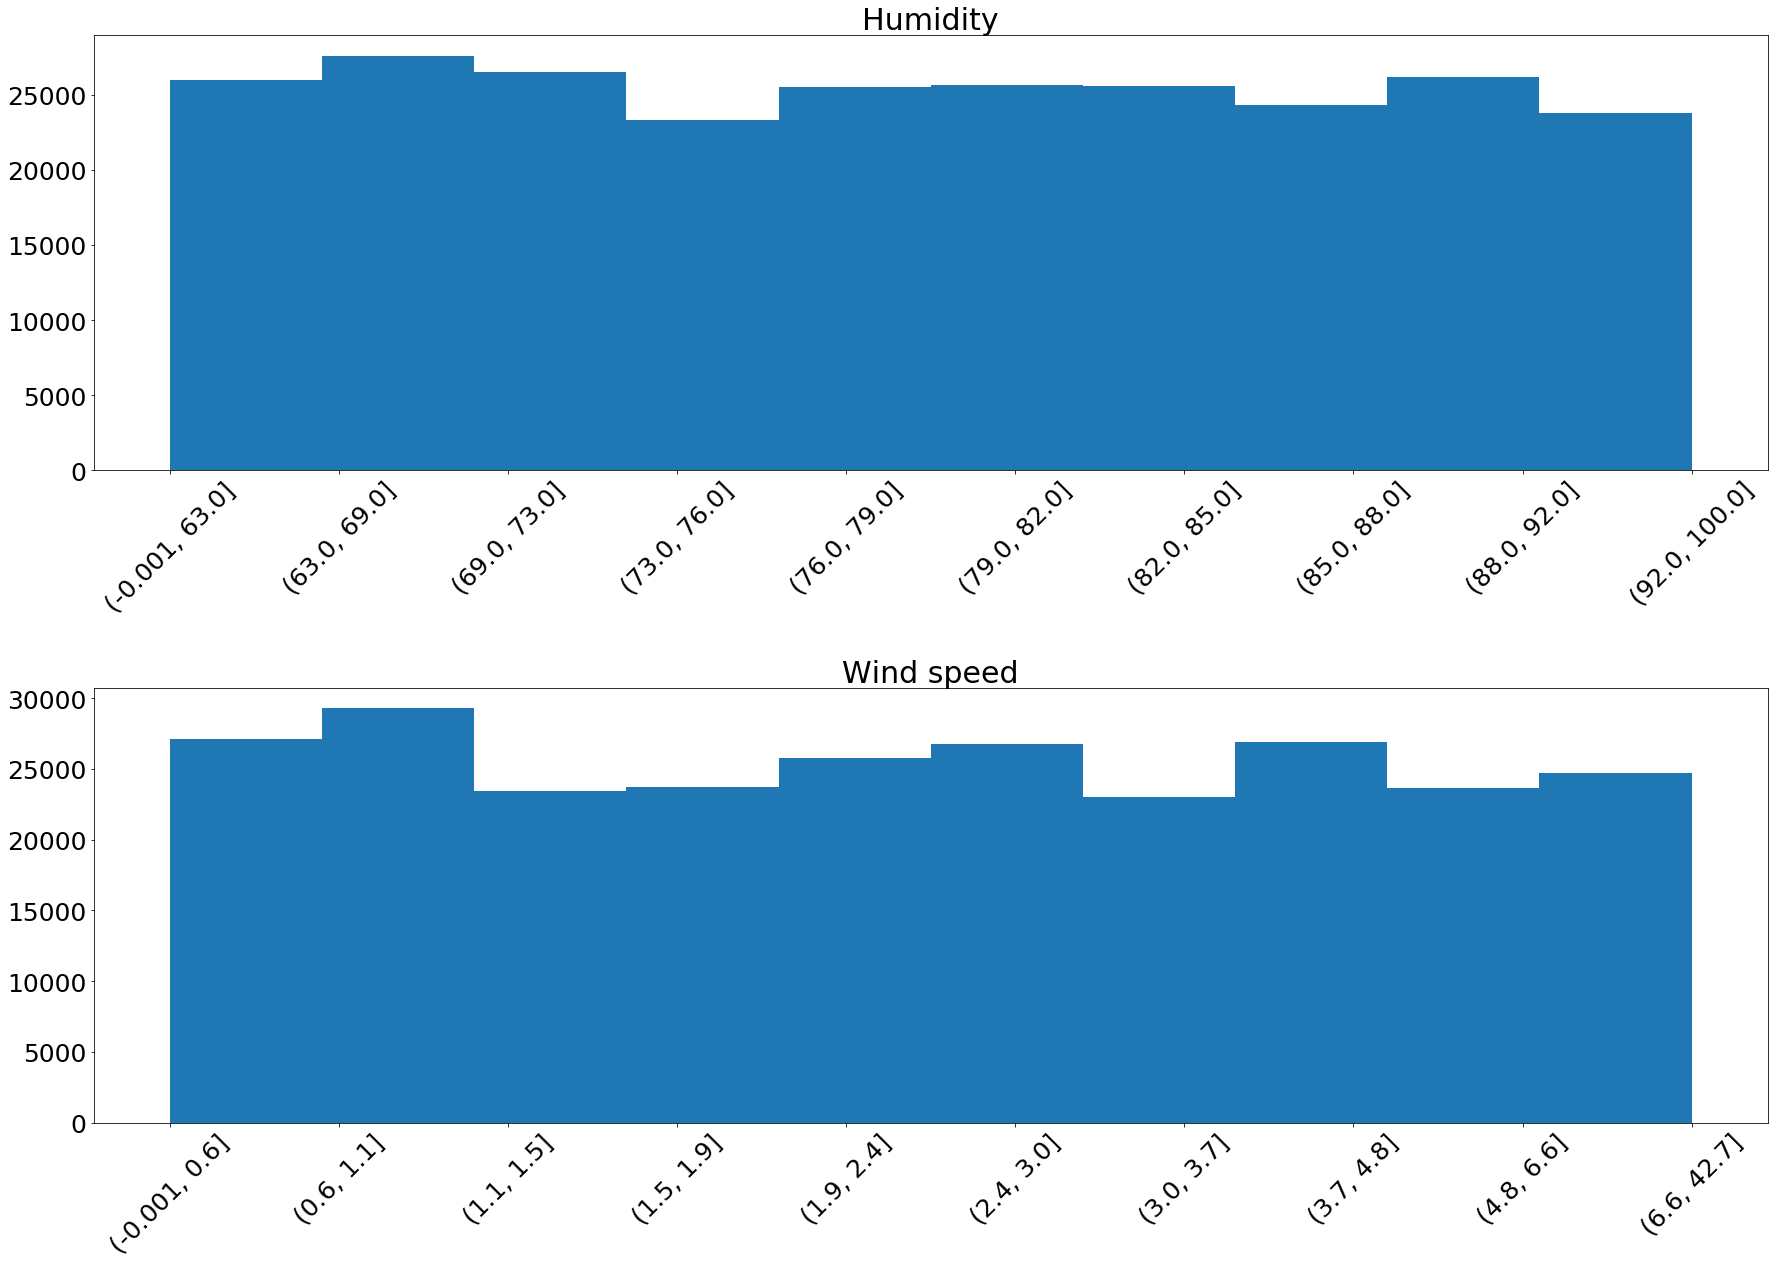

In [22]:
result = []
result.append(pd.qcut(q1['相對溼度'], 10))
result.append(pd.qcut(q1['風速'], 10))

plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(2,1, figsize=(30, 20))
plt.rcParams.update({'font.size': 25})
fig.subplots_adjust(hspace=0.5)
title = ['Humidity', 'Wind speed']
for i in range(len(result)):
    result[i] = [str(x) for x in result[i]]
    ax[i].hist(result[i])
    ax[i].set_title(title[i])
    for tick in ax[i].get_xticklabels():
        # tick.set_y(1)
        tick.set_rotation(45)

### Step 3: Association Rules by FP-Growth:

In [23]:
# Add prefix for clarification
time_items = ['Time_' + x for x in q1['Time_discre']]
temp_items = ['Temp' + x for x in q1['T_cluster']]
humi_items = ['Humi' + x for x in result[0]]
wind_items = ['wind' + x for x in result[1]]

dataset = []
dataset.append(time_items)
dataset.append(temp_items)
dataset.append(humi_items)
dataset.append(wind_items)

# Transpose to generater the format of transactions
transactions = list(zip(*dataset))
transactions

[('Time_Night', 'Temp[25, 27]', 'Humi(82.0, 85.0]', 'wind(0.6, 1.1]'),
 ('Time_Night', 'Temp[25, 27]', 'Humi(82.0, 85.0]', 'wind(-0.001, 0.6]'),
 ('Time_Night', 'Temp[25, 27]', 'Humi(82.0, 85.0]', 'wind(-0.001, 0.6]'),
 ('Time_Night', 'Temp[22, 25]', 'Humi(82.0, 85.0]', 'wind(0.6, 1.1]'),
 ('Time_Night', 'Temp[22, 25]', 'Humi(82.0, 85.0]', 'wind(-0.001, 0.6]'),
 ('Time_Night', 'Temp[22, 25]', 'Humi(82.0, 85.0]', 'wind(0.6, 1.1]'),
 ('Time_Day', 'Temp[25, 27]', 'Humi(82.0, 85.0]', 'wind(-0.001, 0.6]'),
 ('Time_Day', 'Temp[27, 30]', 'Humi(73.0, 76.0]', 'wind(-0.001, 0.6]'),
 ('Time_Day', 'Temp[30, 38]', 'Humi(69.0, 73.0]', 'wind(-0.001, 0.6]'),
 ('Time_Day', 'Temp[30, 38]', 'Humi(-0.001, 63.0]', 'wind(-0.001, 0.6]'),
 ('Time_Day', 'Temp[30, 38]', 'Humi(-0.001, 63.0]', 'wind(-0.001, 0.6]'),
 ('Time_Day', 'Temp[30, 38]', 'Humi(-0.001, 63.0]', 'wind(0.6, 1.1]'),
 ('Time_Day', 'Temp[30, 38]', 'Humi(-0.001, 63.0]', 'wind(1.5, 1.9]'),
 ('Time_Day', 'Temp[30, 38]', 'Humi(-0.001, 63.0]', 'wind(1

#### FP-Growth:
Orange3-fpgrowth can only deal with numeric data, so a pair of encoder/decoder is required

In [24]:
# Orange3's input must be mumeric. String is not allowed.
from orangecontrib.associate import fpgrowth as fpg
start = time.time()

itemset = set().union(*transactions)
# decoder: numeric to string
decoder = {i: k for i, k in enumerate(itemset)}
# encoder: string to numeric
encoder = {k: i for i, k in enumerate(itemset)}

# Set min. support and min. confidence
# Fine-tuning minsup and minconf can get us more insight! Try different values of them.
minsup = 800/len(transactions)
minconf = 0.7

itemsets =  dict(fpg.frequent_itemsets([[encoder[i] for i in t] for t in transactions], minsup))
rules = list(fpg.association_rules(itemsets, minconf))

print("Fpgrowth took", time.time() - start, "seconds.")
# Print # of rules
print(len(rules), "Results")

Fpgrowth took 1.4998669624328613 seconds.
43 Results


In [25]:
for rule in rules:
    a = [decoder[i] for i in rule[0]]
    b = [decoder[i] for i in rule[1]]
    s, c = rule[2], rule[3]
    print(a, ' -> ', b, c)
# c = confidence
# a -> b is the rule

['Humi(88.0, 92.0]', 'wind(-0.001, 0.6]', 'Temp[25, 27]']  ->  ['Time_Night'] 0.76522506619594
['wind(-0.001, 0.6]', 'Humi(85.0, 88.0]', 'Temp[25, 27]']  ->  ['Time_Night'] 0.7822808671065034
['Temp[30, 38]', 'wind(2.4, 3.0]', 'Humi(63.0, 69.0]']  ->  ['Time_Day'] 0.964245810055866
['Humi(63.0, 69.0]', 'Temp[25, 27]']  ->  ['Time_Day'] 0.7554721701063164
['Humi(63.0, 69.0]', 'Temp[27, 30]']  ->  ['Time_Day'] 0.7302459445316588
['Humi(63.0, 69.0]', 'wind(3.7, 4.8]']  ->  ['Time_Day'] 0.7071762441572724
['wind(3.7, 4.8]', 'Temp[27, 30]']  ->  ['Time_Day'] 0.7131367292225201
['wind(2.4, 3.0]', 'Humi(63.0, 69.0]']  ->  ['Time_Day'] 0.7247893054344667
['Humi(88.0, 92.0]', 'wind(-0.001, 0.6]']  ->  ['Time_Night'] 0.7136404697380307
['Humi(88.0, 92.0]', 'Temp[25, 27]']  ->  ['Time_Night'] 0.7063724733837371
['wind(3.7, 4.8]', 'Humi(-0.001, 63.0]']  ->  ['Time_Day'] 0.7477876106194691
['Temp[19, 22]', 'Humi(-0.001, 63.0]']  ->  ['Time_Day'] 0.7021168069370058
['Temp[25, 27]', 'Humi(-0.001, 63.

In [26]:
# decoder

In [27]:
# encoder

### Step 4: Explanation and Conclusion
- [Low humidity + high temperature] -> [Day time]
    - Rules: 
        - ['Humi(63.0, 69.0]', 'Temp[25, 27]']  ->  ['Time_Day'] 0.7554721701063164
        - ['Humi(63.0, 69.0]', 'Temp[27, 30]']  ->  ['Time_Day'] 0.7302459445316588
        - ['Humi(-0.001, 63.0]', 'Temp[19, 22]']  ->  ['Time_Day'] 0.7021168069370058
        - ['Humi(-0.001, 63.0]', 'Temp[25, 27]']  ->  ['Time_Day'] 0.9021739130434783
        - ['Humi(-0.001, 63.0]', 'Temp[27, 30]']  ->  ['Time_Day'] 0.8411584028082493
        - ['Humi(73.0, 76.0]', 'Temp[30, 38]']  ->  ['Time_Day'] 0.9536995006808897
        - ['Humi(76.0, 79.0]', 'Temp[30, 38]']  ->  ['Time_Day'] 0.9669811320754716
        - ['Humi(-0.001, 63.0]', 'Temp[30, 38]']  ->  ['Time_Day'] 0.949305847707194
        - ['Humi(63.0, 69.0]', 'Temp[30, 38]']  ->  ['Time_Day'] 0.9575757575757575
        - ['Humi(69.0, 73.0]', 'Temp[30, 38]']  ->  ['Time_Day'] 0.9550706033376123
    - In short, [Humidity < 79] + [temperature > 19] -> [Day time]: can be easily observed in the association rules shown in the above.
    - At day time, the highest humidity is 79. Although it is still a little bit high, it is ralatively lower than night time.
    - At day time, the lowest temperature is 19.
    - Interpretation: Having the above conditions coincide at the same time implies a day time.
    - Setting: minsup = 800/len(transactions), minconf = 0.7
- [High humidity + low wind speed] -> [Night time]
    - Rules:
        - ['Humi(88.0, 92.0]', 'wind(-0.001, 0.6]']  ->  ['Time_Night'] 0.7136404697380307
        - ['Humi(85.0, 88.0]', 'wind(-0.001, 0.6]']  ->  ['Time_Night'] 0.7195694176097157
        - ['wind(0.6, 1.1]', 'Humi(85.0, 88.0]']  ->  ['Time_Night'] 0.7004364089775561
        - ['Humi(85.0, 88.0]', 'wind(1.5, 1.9]']  ->  ['Time_Night'] 0.7028571428571428
        - ['Humi(85.0, 88.0]', 'wind(1.1, 1.5]']  ->  ['Time_Night'] 0.7100542344597414
        - ['Humi(88.0, 92.0]', 'wind(1.1, 1.5]']  ->  ['Time_Night'] 0.7267801857585139
    - In short, [Humidity > 85] + [wind speed < 1.9] -> [Night time]: can be easily observed in the association rules shown in the above.
    - At night time, the lowest humidity is 85. It is higher than the day time.
    - At night time, the highest wind speed is 1.9, which is low.
    - Interpretation: Having the above conditions coincide at the same time implies a night time.
    - Setting: minsup = 800/len(transactions), minconf = 0.7